# Unsupervised learning on rock properties

Sometimes we don't have labels, but would like to discover structure in a dataset. This is what clustering algorithms attempt to do. They don't require labels from us &mdash; they are 'unsupervised'.

We'll use a subset of the [Rock Property Catalog](http://subsurfwiki.org/wiki/Rock_Property_Catalog) data, licensed CC-BY Agile Scientific. Note that the data have been preprocessed, including the addition of noise to the density data.

We'll use two unsupervised clustering techniques:

- k-means clustering
- DBSCAN
- HDBSCAN

And two unsupervised dimensionality reduction techniques:

- t-SNE
- UMAP

We do have lithology labels for this dataset (normally in an unsupervised problem you wouldn't have labels), so we can use those as a measure of how well we're doing with the clustering.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/RPC_4_lithologies.csv')

In [3]:
df.describe()

,Unnamed: 0,RPC,Vp,Vs,Rho,Rho_n
count,800.000000,800.000000,800.000000,800.000000,752.000000,752.000000
mean,2275.178750,102276.178750,3798.453532,2113.480238,2316.454788,2318.523699
std,1537.850865,1537.850865,1114.387572,750.387638,255.652892,256.254305
min,30.000000,100031.000000,1490.711927,441.270000,1750.000000,1721.753509
25%,1111.750000,101112.750000,3010.248889,1520.975000,2117.000000,2115.586918
50%,2080.500000,102081.500000,3675.150000,2198.100000,2390.000000,2382.642687
75%,3283.750000,103284.750000,4664.592178,2733.805000,2530.000000,2529.145923
max,5089.000000,105090.000000,5993.000000,3665.000000,2780.000000,2823.287733


Notice that the count of `Rho` values is smaller than for the other properties.

Pairplots are a good way to see how the various features are distributed with respect to each other:

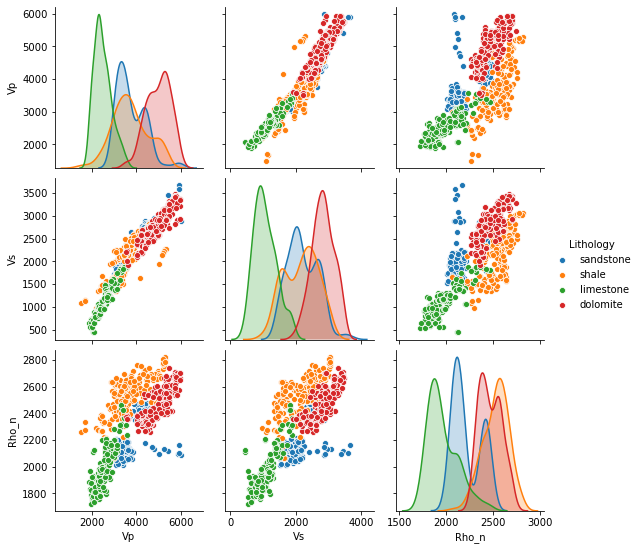

In [4]:
features = ['Vp', 'Vs', 'Rho_n']

sns.pairplot(df.dropna(), vars=features, hue='Lithology')

## Clustering with _k_-means

From [the Wikipedia article](https://en.wikipedia.org/wiki/K-means_clustering):

> k-means clustering is a method of vector quantization, originally from signal processing, that is popular for cluster analysis in data mining. k-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells.

In [5]:
from sklearn.cluster import KMeans

In [144]:
clu = KMeans()

# This will fail...
clu.fit(df[features].values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

The old classic: NaNs. Remember the count of `Rho` points being smaller than the others?

The easiest thing to do, assuming we have the data, is to drop the rows with NaNs.

In [145]:
df = df.dropna()

In [146]:
clu.fit(df[features])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [147]:
df['Kmeans'] = clu.predict(df[features].values)

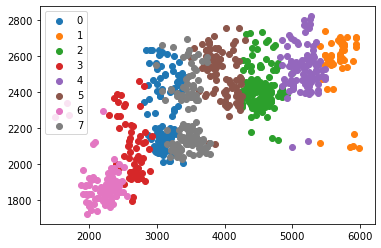

In [10]:
for name, group in df.groupby('K means'):
    plt.scatter(group.Vp, group.Rho_n, label=name)
plt.legend()

We actually do have the labels, so let's compare...

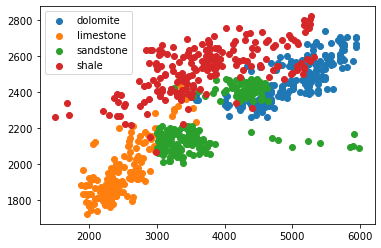

In [11]:
for name, group in df.groupby('Lithology'):
    plt.scatter(group.Vp, group.Rho_n, label=name)
plt.legend()

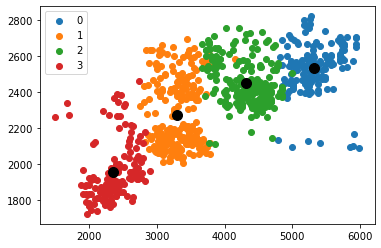

In [29]:
clu = KMeans(n_clusters=4)
df['K means'] = clu.fit_predict(df[features])
for name, group in df.groupby('K means'):
    plt.scatter(group.Vp, group.Rho_n, label=name)
plt.legend()

# We can add the centroids as well:
plt.plot(*clu.cluster_centers_[:, ::2].T, 'o', c='k', ms=10)

## Clustering with DBSCAN

DBSCAN has nothing to do with databases. From [the Wikipedia article](https://en.wikipedia.org/wiki/DBSCAN):

> Density-based spatial clustering of applications with noise (DBSCAN) is [...] a density-based clustering algorithm: given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away). DBSCAN is one of the most common clustering algorithms and also most cited in scientific literature.

In [30]:
from sklearn.cluster import DBSCAN

DBSCAN()

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

There are two important hyperparameters:

- `eps`, the maximum distance between points in the same cluster.
- `min_samples`, the minimum number of samples in a cluster.

In [31]:
clu = DBSCAN(eps=150, min_samples=10)

clu.fit(df[features])

DBSCAN(algorithm='auto', eps=150, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [32]:
df['DBSCAN'] = clu.labels_

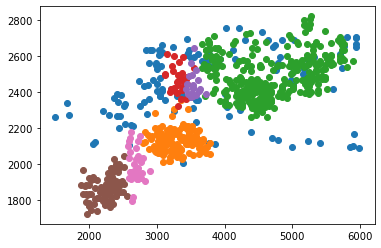

In [33]:
for name, group in df.groupby('DBSCAN'):
    plt.scatter(group.Vp, group.Rho_n, label=name)

It's a bit hard to juggle the two parameters... let's make an interactive widget:

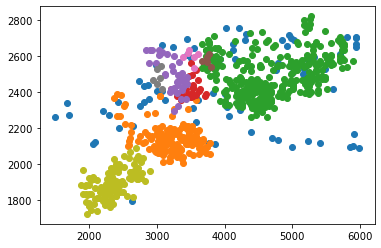

In [35]:
from ipywidgets import interact

@interact(eps=(10, 250, 10))
def plot(eps):
    clu = DBSCAN(eps=eps)
    clu.fit(df[features])
    df['DBSCAN'] = clu.labels_
    for name, group in df.groupby('DBSCAN'):
        plt.scatter(group.Vp, group.Rho_n, label=name)

## HDBSCAN

### Clustering with HDBSCAN

HDBSCAN is an improvement on DBSCAN, but is not yet available in `sklearn`. Install it with:

    conda install -c conda-forge hdbscan

DBSCAN has nothing to do with databases. From [the Wikipedia article](https://en.wikipedia.org/wiki/DBSCAN):

> Density-based spatial clustering of applications with noise (DBSCAN) is [...] a density-based clustering algorithm: given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far away). DBSCAN is one of the most common clustering algorithms and also most cited in scientific literature.

HDBSCAN does away with the epsilon parameter (the maximum distance between points in the same cluster) in DBSCAN, leaving only `n`. So there is only one important hyperparameter:

- `min_samples`, the minimum number of samples in a cluster.

In [ ]:
from hdbscan import HDBSCAN

clu = HDBSCAN(min_samples=10)

clu.fit(df[features])

df['HDBSCAN'] = clu.labels_

Anything the algothim considers to be noise is assigned -1:

In [ ]:
np.unique(clu.labels_)  # -1 is 'noise'

In [ ]:
for name, group in df.groupby('HDBSCAN'):
    plt.scatter(group.Vp, group.Rho_n, label=name)

In [ ]:
from ipywidgets import interact

@interact(min_samples=(1, 60, 2))
def plot(min_samples):
    clu = HDBSCAN(min_samples=min_samples)
    clu.fit(df[features])
    df['HDBSCAN'] = clu.labels_
    for name, group in df.groupby('HDBSCAN'):
        plt.scatter(group.Vp, group.Rho_n, label=name)

## Comparing clusterings

There are metrics for comparing clusterings. For example, `adjusted_rand_score` &mdash; from the scikit-learn docs:

> The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
>
> The raw RI score is then “adjusted for chance” into the ARI score using the following scheme:
> 
> ARI = (RI - Expected_RI) / (max(RI) - Expected_RI)
> 
> The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation).

Conveniently, there is no need for the labels to correspond &mdash; the algorithm just compares whether similar points in one clustering are still similar in the other

In [152]:
from sklearn.metrics import adjusted_rand_score

print(adjusted_rand_score(df.Lithology, df.Kmeans))
print(adjusted_rand_score(df.Lithology, df.DBSCAN))

0.21762023634876748
0.3284809379802243


There are a lot of other clustering algorithms to try. This figure is from [the `sklearn` docs](https://scikit-learn.org/stable/modules/clustering.html):

<img src="../images/sphx_glr_plot_cluster_comparison_0011.png" />

## Manifold embedding with t-SNE

[`t-SNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) was recently implemented in `sklearn`. t-statistic neighbourhood embedding is a popular and very effective dimensionality reduction strategy. The caveat is that distance between clusters is not typically meaningful. But it's at least a useful data exploration tool.

Usually we want `n_components=2`, so we get the data into a 2-space, e.g. for cross-plotting.

In [128]:
from sklearn.manifold import TSNE

tsne = TSNE(init='random', perplexity=100)

embedding = tsne.fit_transform(df[cols].values)

In [129]:
from sklearn.preprocessing import LabelEncoder

labels = LabelEncoder().fit_transform(df.Lithology)

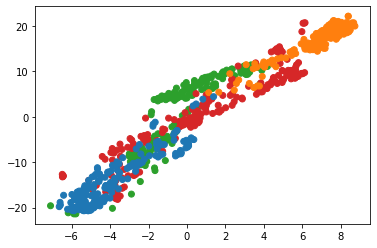

In [155]:
plt.scatter(*embedding.T, c=labels, cmap='tab10', vmax=10)
plt.show()

## Manifolds with UMAP

Another popular tool is UMAP. Check out [`umap-learn`](https://pypi.org/project/umap-learn/). You can install it with 

    conda install -y -c conda-forge umap-learn
    
It has the same interface as `sklearn` so it's very easy to use.

In [139]:
from umap import UMAP

umap = UMAP(metric='euclidean')

embed_umap = umap.fit_transform(df[cols].values)

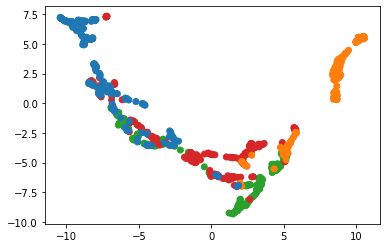

In [140]:
plt.scatter(*embed_umap.T, c=labels, cmap='tab10', vmax=10)
plt.show()

It's fairly common to attempt clustering on the result of the dimensionality reduction, but you should be wary of treating the embedding as a metric space. That is, distances in this space may not correspond to any natural or useful property.

### Exercises

- Can you make the interactive widget display the Rand score? Use `plt.text(x, y, "Text")`.
- Can you write a loop to find the value of `eps` giving the highest Rand score?
- Can you add the `min_samples` parameter to the widget?
- Explore some of [the other clustering algorithms](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster).
- Try some clustering on one of your own datasets (or use something from [sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets), e.g. `sklearn.datasets.load_iris`).